# Download the data

In [ ]:
! wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip"
! unzip "/content/data.zip"
! rm "/content/data.zip"

--2021-04-24 06:42:53--  http://archive.ics.uci.edu/ml/machine-learning-databases/00365/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8834471 (8.4M) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>]   8.42M  12.1MB/s    in 0.7s    

2021-04-24 06:42:54 (12.1 MB/s) - ‘data.zip’ saved [8834471/8834471]

Archive:  /content/data.zip
  inflating: 1year.arff              
  inflating: 2year.arff              
  inflating: 3year.arff              
  inflating: 4year.arff              
  inflating: 5year.arff              


In [ ]:
! pip install missingpy

     |████████████████████████████████| 51kB 4.3MB/s 


# Upload the data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from scipy.io import arff
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [ ]:
N_PERIODS = 5

dfs = []
classes = []

for i in range(N_PERIODS):
    arff_df = arff.loadarff(f'/content/{i + 1}year.arff')
    df_cur = pd.DataFrame(arff_df[0])

    df_cur.loc[df_cur['class'] == b'0', 'class'] = 0
    df_cur.loc[df_cur['class'] == b'1', 'class'] = 1

    dfs.append(df_cur)
    pos_class = sum(df_cur['class'])
    neg_class = df_cur.shape[0] - pos_class
    missing = df_cur.isnull().any(axis=1).sum()

    classes.append([i + 1,
                    pos_class,
                    neg_class,
                    round(pos_class / df_cur.shape[0], 4) * 100,
                    round(neg_class / df_cur.shape[0], 4) * 100,
                    round(missing / df_cur.shape[0], 4) * 100
                    ])

# Pre-processing

In [ ]:
classes_df = pd.DataFrame(classes)
classes_df.columns = ['Dataset', 'Num. of pos. class', 'Num. of neg. class',
                      'Perc. of pos. class', 'Perc. of neg. class',
                      'Perc. of rows with missing']
classes_df = classes_df.set_index('Dataset')
classes_df

,Num. of pos. class,Num. of neg. class,Perc. of pos. class,Perc. of neg. class,Perc. of rows with missing
Dataset,,,,,
1,271,6756,3.86,96.14,54.55
2,400,9773,3.93,96.07,59.82
3,495,10008,4.71,95.29,53.49
4,515,9277,5.26,94.74,51.30
5,410,5500,6.94,93.06,48.71


In [ ]:
df1 = dfs[0]

## Missing values - Exploration

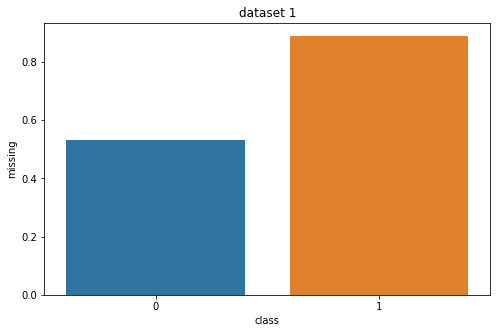

In [ ]:
missing_df = pd.DataFrame({'missing' : df1.isnull().any(axis=1),
                           'class' : df1['class']})

plt.figure(figsize=(8, 5))
sns.barplot(x='class', y='missing', data=missing_df, ci=None)
plt.title('dataset 1')
plt.show()

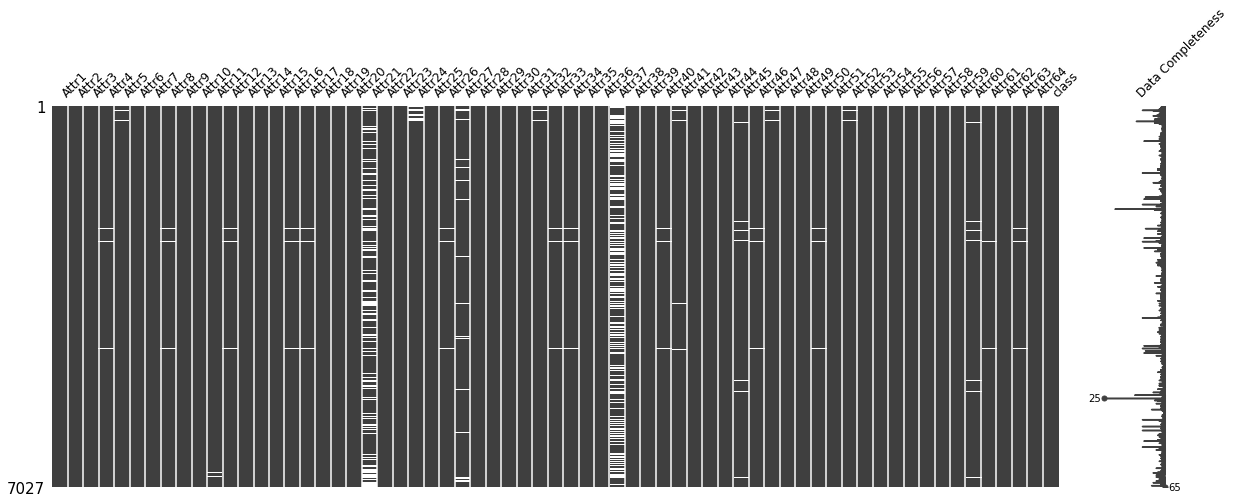

In [ ]:
msno.matrix(df1, labels=True, figsize=(20, 7), fontsize=12)

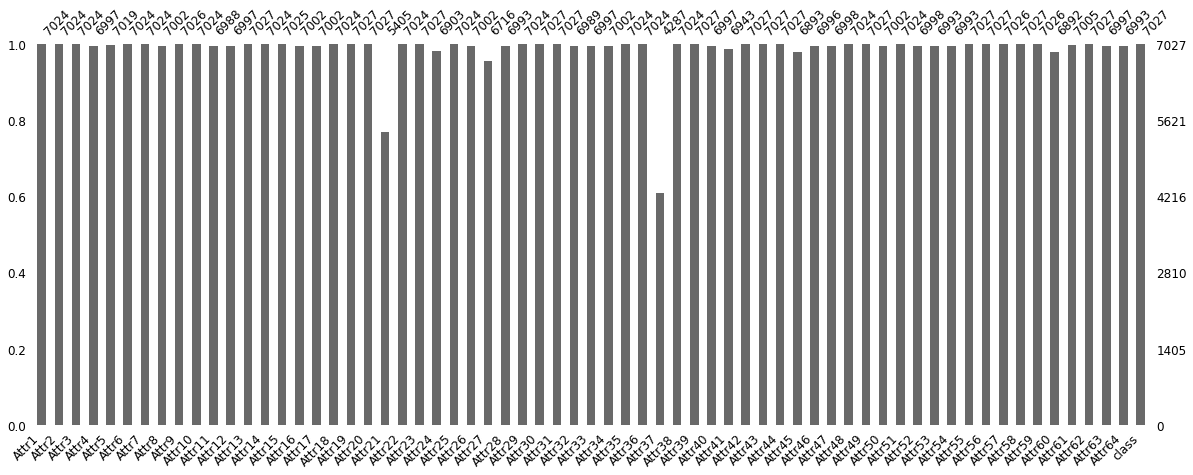

In [ ]:
msno.bar(df1, labels=True, figsize=(20, 7), fontsize=12)

In [ ]:
df1 = df1.drop(['Attr21', 'Attr37'], axis=1)
missing = df1.isnull().any(axis=1).sum()
round(missing / df1.shape[0], 4) * 100

10.09

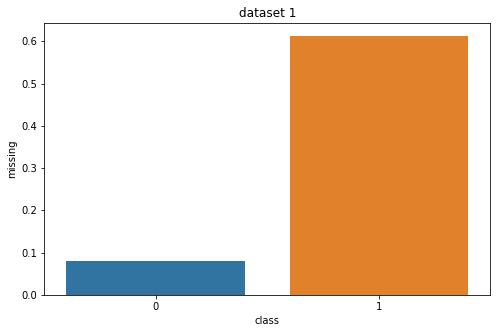

In [ ]:
missing_df = pd.DataFrame({'missing' : df1.isnull().any(axis=1),
                           'class' : df1['class']})

plt.figure(figsize=(8,5))
sns.barplot(x='class', y='missing', data=missing_df, ci=None)
plt.title('dataset 1')
plt.show()

## Correlation analysis

In [ ]:
X = df1.drop(['class'], axis=1)
y = df1['class']

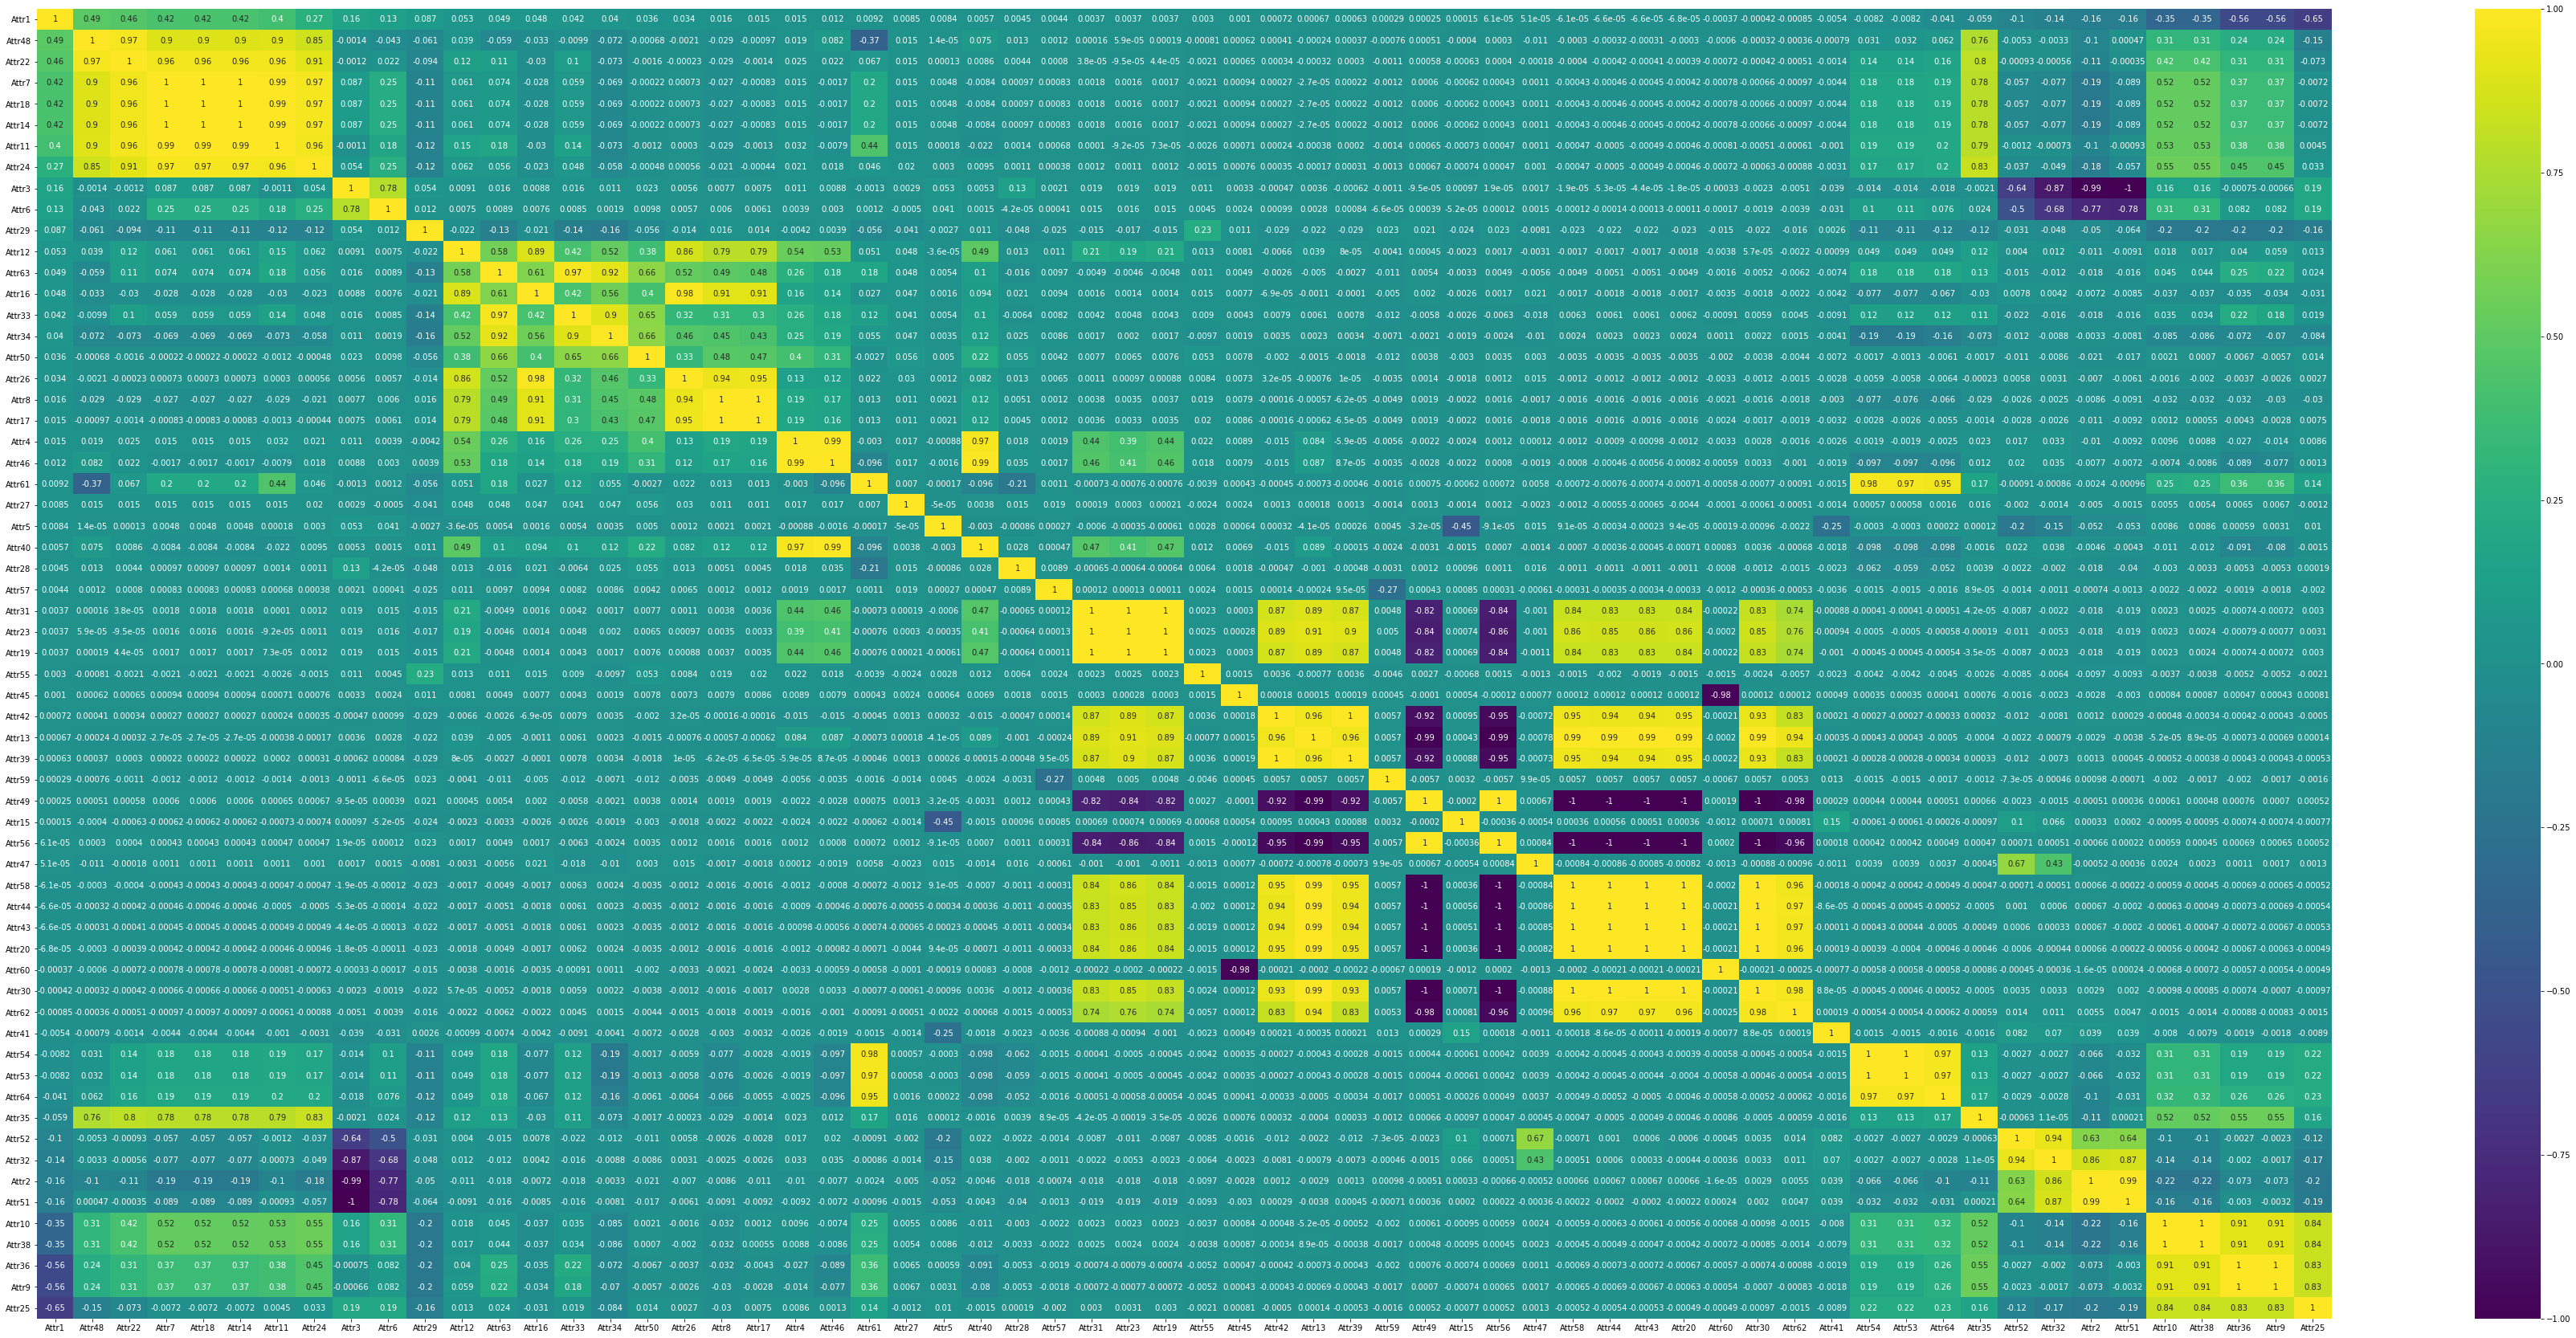

In [ ]:
k = 64
cols = X.corr().nlargest(k, 'Attr1')['Attr1'].index
cm = X[cols].corr()
plt.figure(figsize=(64, 30))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [ ]:
# Gets full data and creates a map of each colum that has correlation with other columns and is higher than 0.9
# Returns a hashmap with keys as variable to keep and value in arrays as highly correlated variables

def corrMapAttributes(arr):
  att = dict();
  reducedArr=arr
 # interval = pd.interval_range(1,64);
  for i in arr:
    for j in reducedArr:
      if(abs(arr[i][j]) >= 0.9 and i != j):
        if i not in att:
          att[i] = list()
        att[i].append(j)
    reducedArr = reducedArr.drop(columns=[i])
  return att

corrArr = X[cols].corr()
corr_att = corrMapAttributes(corrArr)

['Attr48', 'Attr22', 'Attr7', 'Attr18', 'Attr14', 'Attr11', 'Attr3', 'Attr63', 'Attr16', 'Attr33', 'Attr26', 'Attr8', 'Attr4', 'Attr46', 'Attr61', 'Attr31', 'Attr23', 'Attr45', 'Attr42', 'Attr13', 'Attr39', 'Attr49', 'Attr56', 'Attr58', 'Attr44', 'Attr43', 'Attr20', 'Attr30', 'Attr54', 'Attr53', 'Attr52', 'Attr2', 'Attr10', 'Attr38', 'Attr36']
27


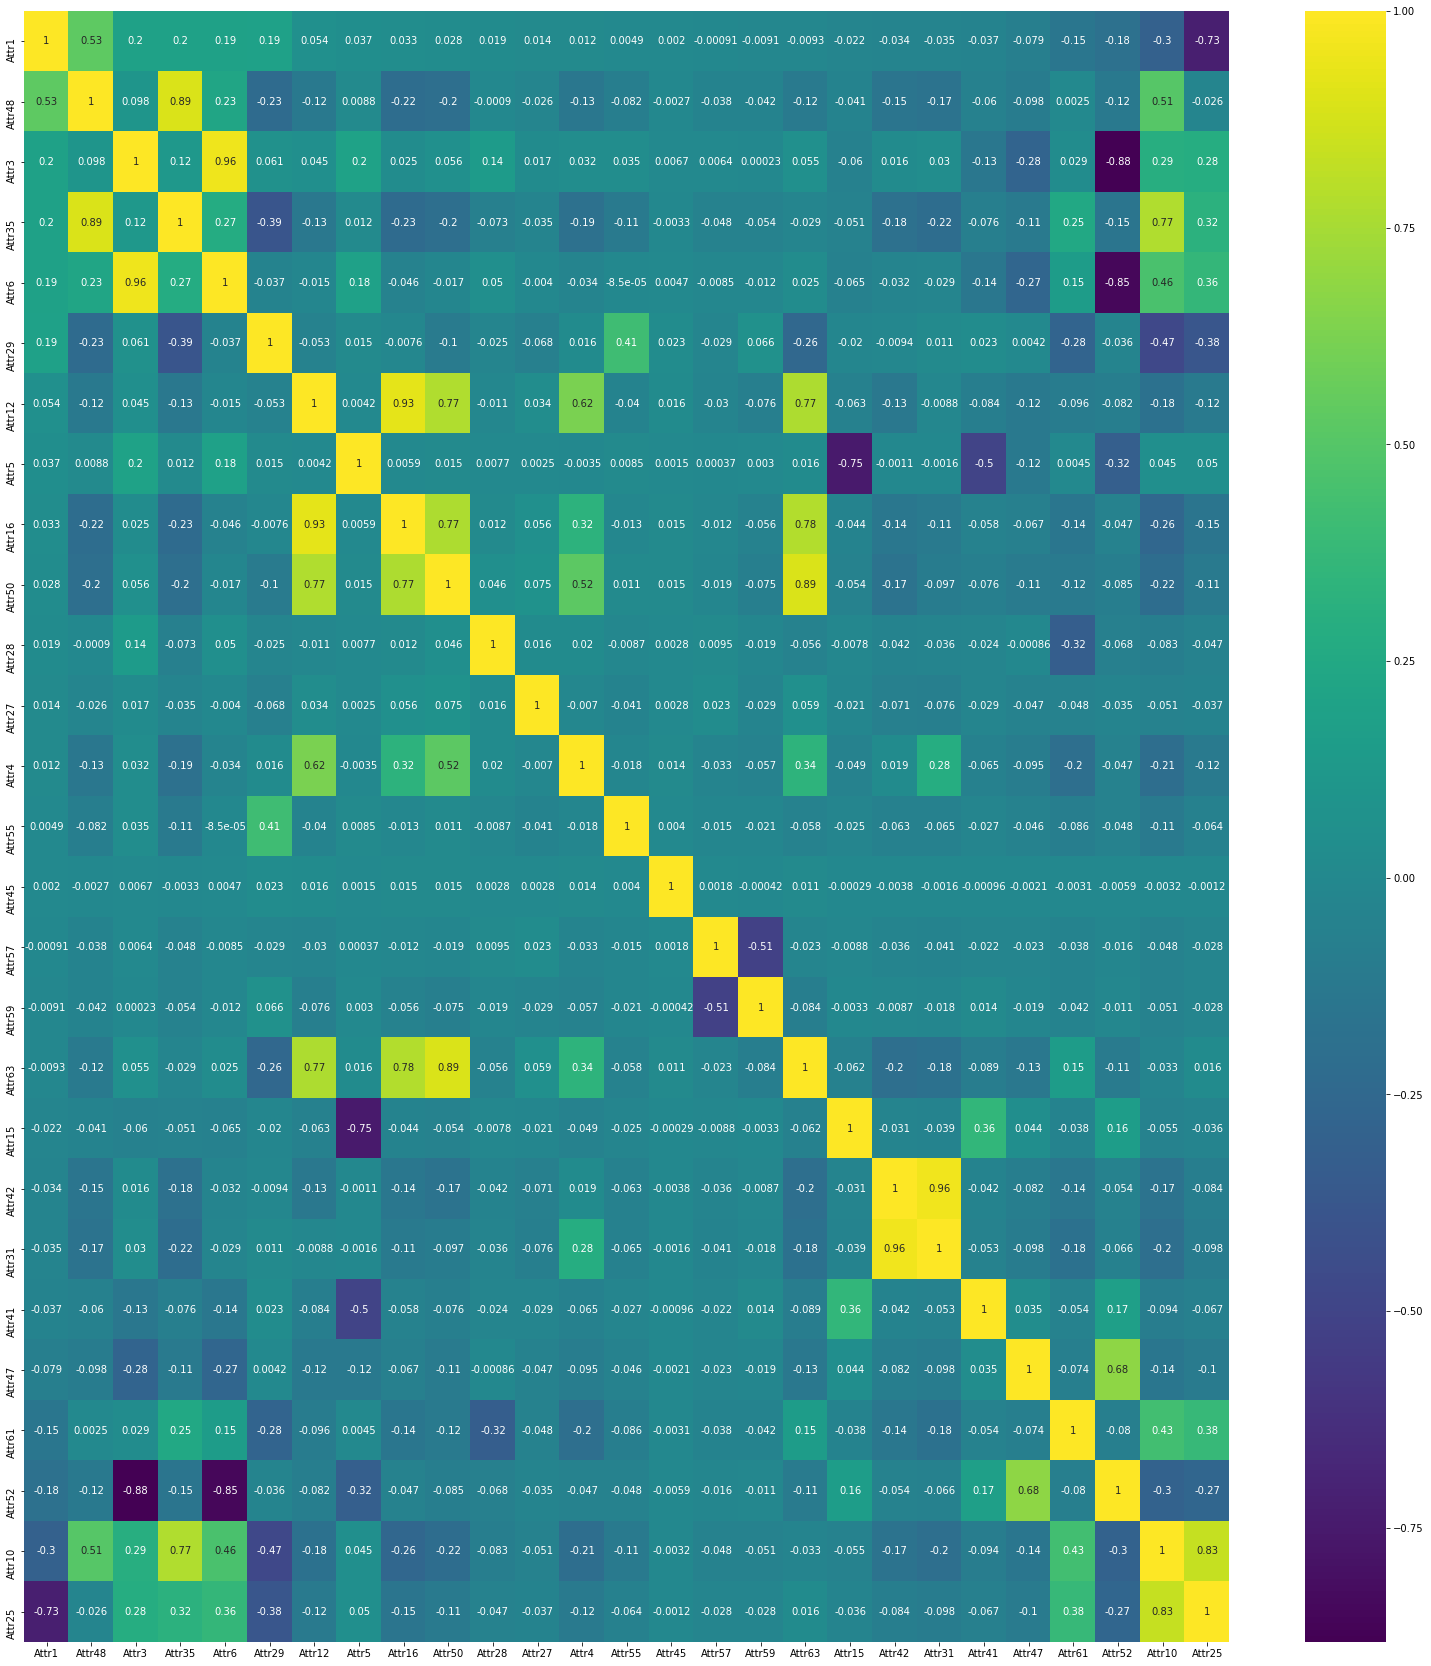

In [ ]:
# Creates a new data frame that has removed all columns in the map, but does not
# remove the key, unless the key is also whithin one of the maps array

def attToDrop(Arr, attTD):
  new_df = Arr
  print(list(attTD.keys()))
  for key in attTD:
    for attri in attTD[key]:
      if attri in new_df:
        new_df = new_df.drop(columns=[attri])
  return new_df

corrs = attToDrop(corrArr, corr_att)
print(len(corrs.columns))
k = len(corrs.columns)
cols = corrs.corr().nlargest(k, 'Attr1')['Attr1'].index
cm = corrs[cols].corr()
plt.figure(figsize=(k, 30))
sns.heatmap(cm, annot=True, cmap='viridis')

In [ ]:
X = X[corrs.columns]

In [ ]:
X = X.drop(['Attr25', 'Attr3', 'Attr63'], axis=1)

## Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2)

y_test = list(y_test.values)
y_train = list(y_train.values)

In [ ]:
X_train.shape

(5621, 24)

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Imputation

In [ ]:
from missingpy import MissForest

imputer = MissForest(max_iter=3, n_estimators=20, max_depth=5, n_jobs=-1)
X_train_imp = imputer.fit_transform(X_train_scaled)
X_train_imp = pd.DataFrame(X_train_imp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Iteration: 0
Iteration: 1
Iteration: 2


In [ ]:
missing = X_train_imp.isnull().any(axis=1).sum()
round(missing / df1.shape[0], 4) * 100

0.0

In [ ]:
X_test_imp = imputer.transform(X_test_scaled)
X_test_imp = pd.DataFrame(X_test_imp)

Iteration: 0
Iteration: 1
Iteration: 2


## Unbalanced data

## Approach 1

In [ ]:
X_neg = X_train_imp[(y_train == 0).values]
X_pos = X_train_imp[(y_train == 1).values]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_samplpes = int(X_neg.shape[0] / sum(y_train))
samples = np.random.choice(X_neg.shape[0], (n_samplpes, sum(y_train)), replace=False)

models = [RandomForestClassifier(n_estimators=100, max_depth=5)] * n_samplpes

for i, sample in enumerate(samples):
    X_neg_cur = X_neg.iloc[sample]
    X_cur = X_pos.append(X_neg_cur)
    y_train_ = [1] * sum(y_train) + [0] * (X_cur.shape[0] - sum(y_train))

    models[i].fit(X_cur, y_train_)

In [ ]:
predictions = []
thr = 0.55

for model in models:
    predictions.append(model.predict_proba(X_test_imp)[:, 1] > thr)

In [ ]:
np.unique(np.array(predictions).sum(axis=0))

array([ 0, 24])

In [ ]:
y_pred = np.array(predictions).sum(axis=0) > 12

In [ ]:
confusion_matrix(list(y_test.values), y_pred)

array([[1671,  357],
       [  31,   50]])

In [ ]:
f1_score(list(y_test.values), y_pred)

0.20491803278688525

## Approach 2

In [ ]:
smote_ratio = sum(y_train) / (len(y_train) - sum(y_train))
1 / smote_ratio

24.903225806451616

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=2*smote_ratio)

X_res, y_res = smote.fit_resample(X_train_imp, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(len(y_res) - sum(y_res)) / sum(y_res)

12.480369515011548

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

renn = EditedNearestNeighbours()
X_resampled, y_resampled = renn.fit_resample(X_res, y_res)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
(len(y_resampled) - sum(y_resampled)) / sum(y_resampled)

10.856812933025404

In [ ]:
from sklearn.cluster import KMeans

kmeans_ratio = 5
kmeans = KMeans(n_clusters=kmeans_ratio * sum(y_resampled))
kmeans.fit(X_resampled[(y_resampled == 0)])
centers = pd.DataFrame(kmeans.cluster_centers_)

In [ ]:
X_app2 = pd.DataFrame(X_resampled[(y_resampled == 1)])
X_app2 = X_app2.append(centers, ignore_index=True)
y_train_ = [1] * sum(y_res) + [0] * (X_app2.shape[0] - sum(y_res))

In [ ]:
(len(y_train_) - sum(y_train_)) / sum(y_train_)

5.0

# Training models

In [ ]:
def custom_f1_score(estimator, X, y):
    y_pred = estimator.predict(X)
    score = f1_score(y, y_pred)
    return score

def grid_search(clf, params, X_, y_):
    grid = GridSearchCV(clf, params, scoring=custom_f1_score, cv=5)
    grid.fit(X_, y_)
    print("Best F1-score: ", grid.best_score_)
    return grid.best_params_

In [ ]:
class_weights = {0 : 1, 1 : (len(y_train_) - sum(y_train_)) / sum(y_train_)}
best_params = []

logreg_params = {'C' : [1e-2, 1e-1, 1, 10, 100],
                 'class_weight' : ['balanced', class_weights]}

svm_params = {'C' : [1e-2, 1e-1, 1, 10, 100],
                'kernel' : ['rbf'],
                'class_weight' : ['balanced', class_weights]}

rf_params = {'n_estimators' : [50, 100, 200],
               'criterion' : ['gini', 'entropy'],
               'max_depth' : [3, 5, 7, None],
               'min_samples_leaf' : [1, 3, 5],
               'class_weight' : ['balanced', class_weights]}

adaboost_params = {'n_estimators' : [50, 100, 200]}

gradboost_params = {'n_estimators' : [50, 100, 200],
                    'max_depth' : [3, 5, 7, None],
                    'min_samples_leaf' : [1, 3, 5]}


clfs = [
        ('LogReg', LogisticRegression(), logreg_params),
        ('SVM', SVC(), svm_params),
        ('RF', RandomForestClassifier(), rf_params),
        ('AdaBoost', AdaBoostClassifier(), adaboost_params),
        ('GradBoosting', GradientBoostingClassifier(), gradboost_params)
]

for clf in clfs:
    print(clf[0])
    best_p = grid_search(clf[1], clf[2], X_app2, y_train_)
    print(best_p)
    best_params.append([clf[0], best_p])

LogReg
Best F1-score:  0.44827132667746367
{'C': 10, 'class_weight': 'balanced'}
SVM
Best F1-score:  0.49058476089873276
{'C': 100, 'class_weight': {0: 1, 1: 5.0}, 'kernel': 'rbf'}
RF
Best F1-score:  0.7715198846569746
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 100}
AdaBoost
Best F1-score:  0.7106488633684652
{'n_estimators': 200}
GradBoosting
Best F1-score:  0.7755603387606474
{'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 100}


# Evaluate models

In [ ]:
def calculate_metrics(y_true, y_pred):
    print("F1-score: ", round(f1_score(y_test, y_pred), 4))
    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 4))
    print("Presicion: ", round(precision_score(y_test, y_pred), 4))
    print("Recall: ", round(recall_score(y_test, y_pred), 4))

In [ ]:
def plot_mat(mat):
    sns.heatmap(mat, annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix')
    plt.show()

## Logistic Regression

In [ ]:
logreg = LogisticRegression(**best_params[0][1])
logreg.fit(X_app2, y_train_)

y_pred = logreg.predict(X_test_imp)
mat = confusion_matrix(y_test, y_pred)

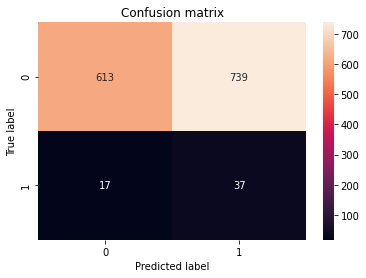

In [ ]:
plot_mat(mat)

In [ ]:
calculate_metrics(y_test, y_pred)

F1-score:  0.0892
Accuracy:  0.4623
Presicion:  0.0477
Recall:  0.6852


## SVM

In [ ]:
svm = SVC(**best_params[1][1])
svm.fit(X_app2, y_train_)

y_pred = svm.predict(X_test_imp)
mat = confusion_matrix(y_test, y_pred)

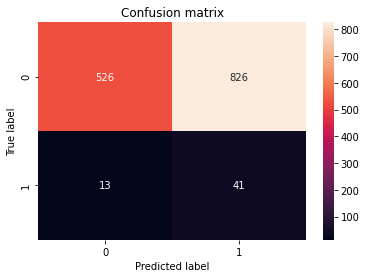

In [ ]:
plot_mat(mat)

In [ ]:
calculate_metrics(y_test, y_pred)

F1-score:  0.089
Accuracy:  0.4033
Presicion:  0.0473
Recall:  0.7593


## Random Forest

In [ ]:
rf = RandomForestClassifier(**best_params[2][1])
rf.fit(X_app2, y_train_)

y_pred = rf.predict(X_test_imp)
mat = confusion_matrix(y_test, y_pred)

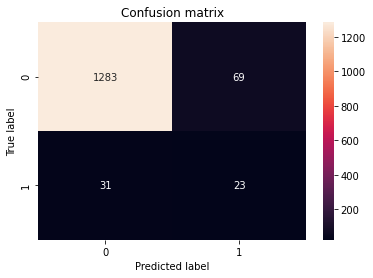

In [ ]:
plot_mat(mat)

In [ ]:
calculate_metrics(y_test, y_pred)

F1-score:  0.3151
Accuracy:  0.9289
Presicion:  0.25
Recall:  0.4259


## AdaBoost

In [ ]:
adaboost = AdaBoostClassifier(**best_params[3][1])
adaboost.fit(X_app2, y_train_)

y_pred = adaboost.predict(X_test_imp)
mat = confusion_matrix(y_test, y_pred)

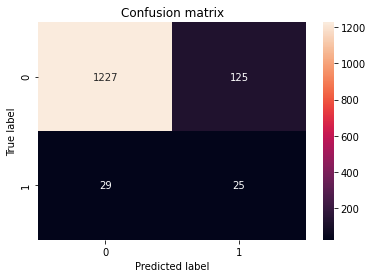

In [ ]:
plot_mat(mat)

In [ ]:
calculate_metrics(y_test, y_pred)

F1-score:  0.2451
Accuracy:  0.8905
Presicion:  0.1667
Recall:  0.463


## Gradient Boosting

In [ ]:
gradboost = GradientBoostingClassifier(**best_params[4][1])
gradboost.fit(X_app2, y_train_)

y_pred = gradboost.predict(X_test_imp)
mat = confusion_matrix(y_test, y_pred)

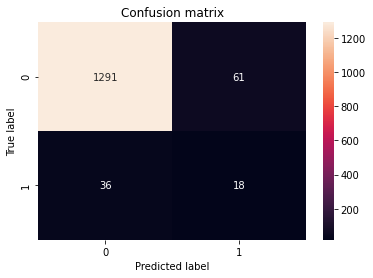

In [ ]:
plot_mat(mat)

In [ ]:
calculate_metrics(y_test, y_pred)

F1-score:  0.2707
Accuracy:  0.931
Presicion:  0.2278
Recall:  0.3333


## XGBoost

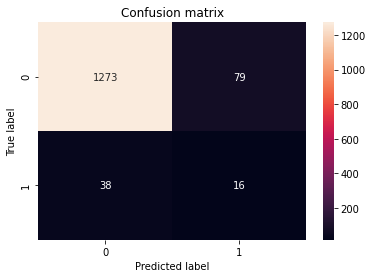

In [ ]:
plot_mat(mat)

In [ ]:
calculate_metrics(y_test, y_pred)

F1-score:  0.4533
Accuracy:  0.9708
Presicion:  0.8095
Recall:  0.3148


# Adding Second Dataset

In [ ]:
def preprocess(df):

    return df

In [ ]:
df2 = df[1]

In [ ]:
df2 = df.append(df1)